<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [1]:
# # Создаем директорию data, если она не существует
# !mkdir -p data

# # Скачиваем файлы в директорию data
# !wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O data/train_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O data/train_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O data/test_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O data/test_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O data/sample_submission.csv

In [2]:
# # Скачиваем файлы с Kaggle
# !pip install kaggle -q

# # Убедимся, что директория для API ключа Kaggle существует
# !mkdir -p ~/.kaggle

# # Создаем файл с API ключом Kaggle (замените на свой ключ)
# # Примечание: в реальном использовании лучше загрузить ключ из безопасного хранилища
# # !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# # !chmod 600 ~/.kaggle/kaggle.json

# # Скачиваем файлы соревнования
# !kaggle competitions download -c fraud-detection-24 -p data
# !unzip -o data/fraud-detection-24.zip -d data


In [ ]:
# %pip install catboost -q

In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
INPUT_DIR = 'data'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [3]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [4]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 91489.70it/s]


In [6]:
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

# cb = CatBoostClassifier(iterations=3)
# cb.fit(X_train, y_train, object_cols, )

In [10]:
# predictions = cb.predict_proba(df_test.fillna(''))

In [11]:
# sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
# sub.head()

In [12]:
# Сохранение submission
# sub.to_csv('submission_baseline.csv', index=False)

In [13]:
# Отправка файла на соревнование
# !kaggle competitions submit -c fraud-detection-24 -f submission_baseline.csv -m "Базовая модель CatBoost"

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

## Анализ признаков

In [8]:
# ваш EDA здесь
print("\nИнформация о тренировочном наборе:")
df_train.info(verbose=False)


Информация о тренировочном наборе:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB


- в обучающей выборке 432 признака, включая целевую `isFraud`.
- типы данных : float64(399), int64(2), object(31)
- датасет занимает 1.3ГБ памяти, что много. Возможно типы данных неэффективно выбораны.

### Оптимизируем типы данных

In [9]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти до оптимизации: {:.2f} MB'.format(start_mem))
    for col in tqdm(df.columns):
        if df[col].dtype not in ['object', 'category']: 

            is_NAN_or_INF = np.isfinite(df[col]).any() or df[col].isna().any()

            if np.all(np.abs(df[col].dropna() - df[col].dropna().round()) < 1e-15):
                rounded = df[col].dropna().round()
                rmin = rounded.min()
                rmax = rounded.max()

                if rmin >= 0:
                    if rmax < np.iinfo(np.uint8).max:
                        dtype_nullable = 'UInt8'
                        dtype_regular = np.uint8
                    elif rmax < np.iinfo(np.uint16).max:
                        dtype_nullable = 'UInt16'
                        dtype_regular = np.uint16
                    elif rmax < np.iinfo(np.uint32).max:
                        dtype_nullable = 'UInt32'
                        dtype_regular = np.uint32
                    else:
                        dtype_nullable = 'UInt64'
                        dtype_regular = np.uint64
                else:
                    if rmin > np.iinfo(np.int8).min and rmax < np.iinfo(np.int8).max:
                        dtype_nullable = 'Int8' 
                        dtype_regular = np.int8
                    elif rmin > np.iinfo(np.int16).min and rmax < np.iinfo(np.int16).max:
                        dtype_nullable = 'Int16'
                        dtype_regular = np.int16
                    elif rmin > np.iinfo(np.int32).min and rmax < np.iinfo(np.int32).max:
                        dtype_nullable = 'Int32'
                        dtype_regular = np.int32
                    elif rmin > np.iinfo(np.int64).min and rmax < np.iinfo(np.int64).max:
                        dtype_nullable = 'Int64'
                        dtype_regular = np.int64
                # Применяем выбранный тип данных
                try:
                    df[col] = df[col].astype(dtype_nullable) if is_NAN_or_INF else rounded.astype(dtype_regular)
                except:
                    print(f"Ошибка на {col}: {df[col].dtype} -> {dtype_nullable=}, {dtype_regular=}, {is_NAN_or_INF=}, {rmin=}, {rmax=}")
                    df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float32)
        else:  # тип object пытаемся преобразовать в category
            try:
                df[col] = df[col].astype('category')
            except:
                print(f"Ошибка на {col}: {df[col].dtype} -> 'category'")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшение памяти на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [10]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Использование памяти до оптимизации: 1376.23 MB


100%|██████████| 432/432 [00:12<00:00, 34.05it/s]


Использование памяти после оптимизации: 416.20 MB
Уменьшение памяти на 69.8%
Использование памяти до оптимизации: 568.81 MB


100%|██████████| 431/431 [00:05<00:00, 78.76it/s] 

Использование памяти после оптимизации: 174.10 MB
Уменьшение памяти на 69.4%


Использование памяти сократилось примерно в 3 раза.

| Занято памяти | До оптимизации | После оптимизации | Уменьшение |
|---------------|----------------|-------------------|------------|
| df_train      | 1376.23 MB     | 416.2 MB          | 69.8%      |
| df_test       |  568.81 MB     | 174.1 MB          | 69.4%      |

In [11]:
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud']
X_test = df_test.copy()

In [32]:
numeric_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

### Пропуски

In [ ]:
# сохраним для тренировочных данных - понадобятся позже
missing_train = X_train.isnull().sum()
missing_train = missing_train.sort_values(ascending=False)
missing_train_prc = missing_train / len(df_train) * 100
missing_train[missing_train > 0].count()

371

In [30]:
df_test.isnull().sum().pipe(lambda x: x>0).sum()

382

**Пропуски**
| df_train | df_test |
|----------|---------|
| 371      | 382     |


Число признаков с пропусками в тестовых данных больше! 

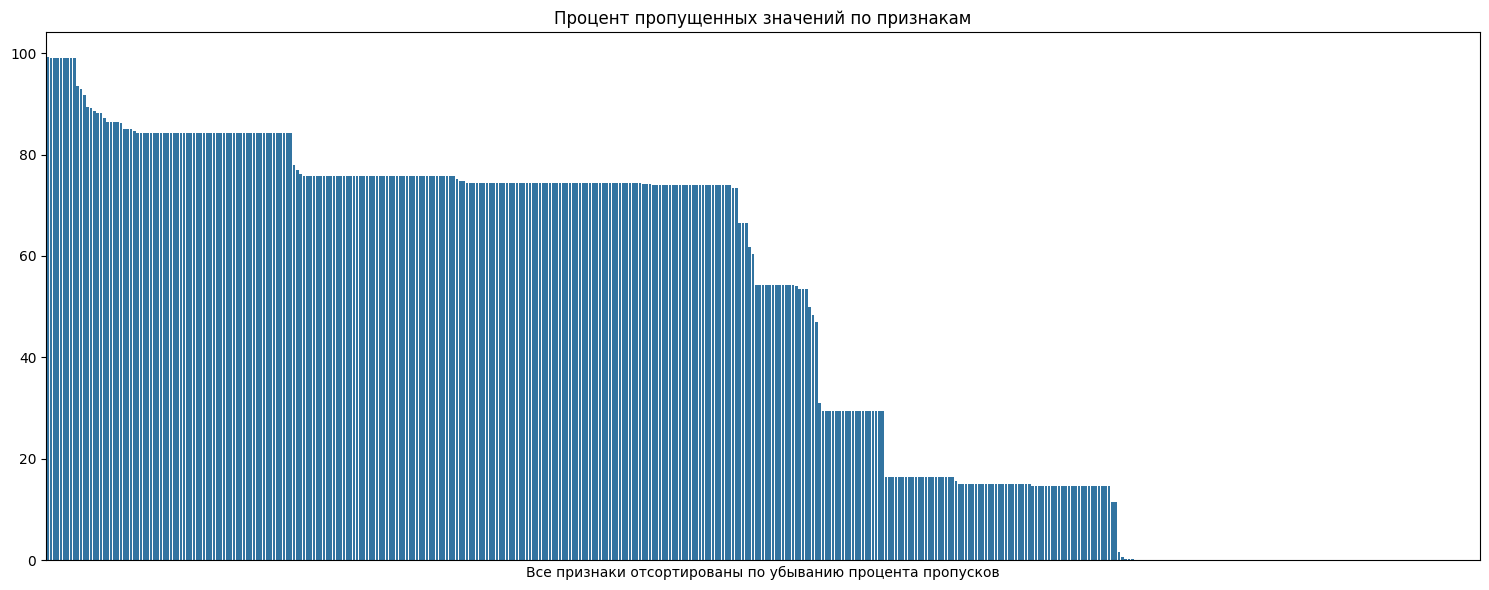

In [31]:
# Визуализация пропущенных значений
plt.figure(figsize=(15, 6))
sns.barplot(x=missing_train_prc.index, y=missing_train_prc.values)
plt.title('Процент пропущенных значений по признакам')
plt.xlabel('Все признаки отсортированы по убыванию процента пропусков')
plt.xticks([])
plt.tight_layout()
plt.show()

##### Вывод

1. Пропусков много
   - около половины признаков имеют более 70% пропусков.  
   - Выделяются группы признаков с одинаковыми уровнями пропусков (в %%). Можно предположить, что это данные из одних источников, описывающие связанные признаки.

2. Что делать
   - продумать стратегию заполнения пропусков после анализа переменных или ...
   - ... использовать модели, которые сами обрабатывают пропуски (CatBoost, LightGBM)

### Корреляция с целевой переменной

In [63]:
# Анализ корреляции признаков с целевой переменной
def analyze_target_correlations_numeric(X, y):
    """
    Анализирует корреляцию признаков с целевой переменной
    Args:
        X: DataFrame с признаками
        y: Series или array с целевой переменной
        top_n: число топ признаков для вывода
    Returns:
        DataFrame с отсортированными корреляциями
    """
    # Преобразуем y в Series если это np.array
    y = pd.Series(y) if isinstance(y, np.ndarray) else y
    
    # Получаем числовые признаки
    num_feat = X.select_dtypes(exclude=['object', 'category']).columns
    
    # Вычисляем корреляции для всех числовых признаков сразу
    correlations = pd.DataFrame(index=num_feat, columns=['correlation', 'method', 'missing_pct'])
    
    for feature in num_feat:
        # Используем только непропущенные значения
        mask = ~X[feature].isnull()
        if mask.sum() > 0:
            correlation = abs(X[feature][mask].corr(y[mask]))
            missing_pct = (1 - mask.mean()) * 100
            correlations.loc[feature] = [correlation, 'pairwise', missing_pct]
    
    # Сортируем по модулю корреляции
    correlations = correlations.sort_values('correlation', ascending=False)
    
    return correlations

# Анализируем корреляции
tgt_corrs = analyze_target_correlations_numeric(X_train, y_train)


/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


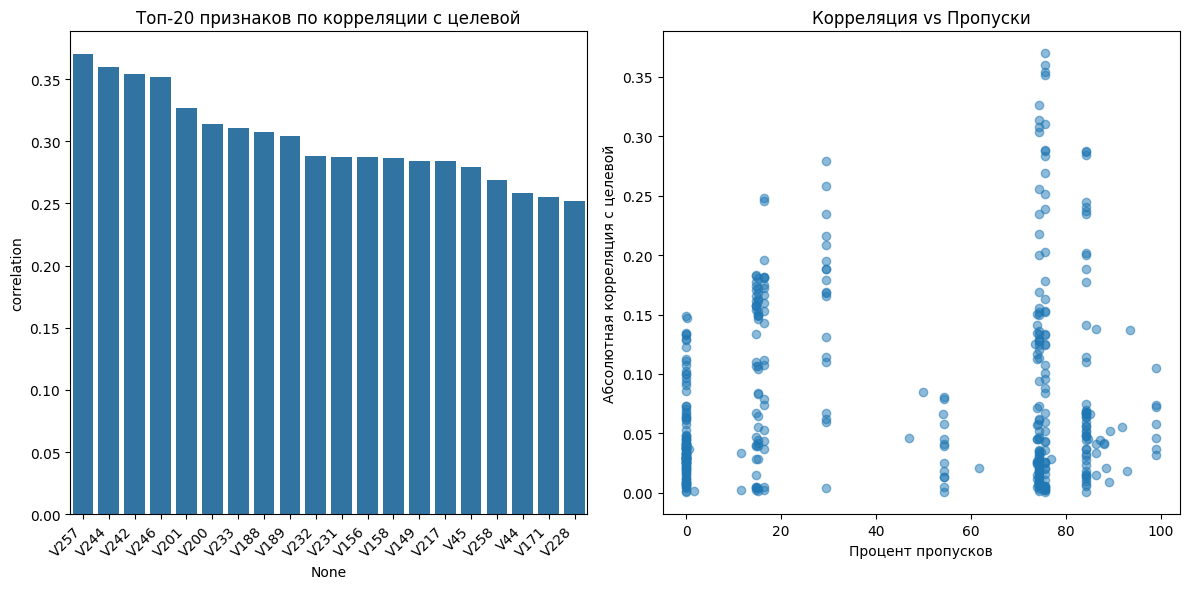


Топ-20 признаков с наибольшей корреляцией:
     correlation    method missing_pct
V257    0.369941  pairwise   75.691339
V244    0.359899  pairwise   75.691339
V242    0.354488  pairwise   75.691339
V246    0.351318  pairwise   75.691339
V201    0.326478  pairwise   74.300877
V200    0.313537  pairwise   74.300877
V233    0.310822  pairwise   75.691339
V188    0.307764  pairwise   74.300877
V189    0.303891  pairwise   74.300877
V232    0.288307  pairwise   75.691339
V231     0.28753  pairwise   75.691339
V156    0.287339  pairwise   84.314552
V158    0.286551  pairwise   84.314552
V149    0.284183  pairwise   84.314552
V217    0.283805  pairwise   75.691339
V45     0.279115  pairwise   29.477271
V258    0.269148  pairwise   75.691339
V44      0.25837  pairwise   29.477271
V171     0.25553  pairwise   74.300877
V228    0.251739  pairwise   75.691339


In [64]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

#  топ-20 корреляций
plt.subplot(1, 2, 1)
top_correlations = tgt_corrs.head(20)
sns.barplot(x=top_correlations.index, y='correlation', data=top_correlations)
plt.xticks(rotation=45, ha='right')
plt.title('Топ-20 признаков по корреляции с целевой')
plt.tight_layout()

# Scatter plot для процента пропусков vs корреляция
plt.subplot(1, 2, 2)
plt.scatter(tgt_corrs['missing_pct'], tgt_corrs['correlation'], alpha=0.5)
plt.xlabel('Процент пропусков')
plt.ylabel('Абсолютная корреляция с целевой')
plt.title('Корреляция vs Пропуски')

plt.tight_layout()
plt.show()

# Выводим топ признаки с их характеристиками
print("\nТоп-20 признаков с наибольшей корреляцией:")
print(tgt_corrs.head(20).round(3))


In [67]:
def analyze_target_correlations_categorical(X, y):
    """
    Анализирует корреляцию категориальных признаков с целевой переменной
    используя Cramer's V для категориальных и точечно-бисериальную корреляцию для порядковых
    
    Args:
        X: DataFrame с признаками
        y: Series с целевой переменной
        top_n: число топ признаков для вывода
    Returns:
        DataFrame с метриками корреляции
    """
    from scipy.stats import chi2_contingency, pointbiserialr
    
    # Получаем категориальные признаки
    cat_feat = X.select_dtypes(include=['object', 'category']).columns
    
    # Создаем DataFrame для результатов
    correlations = pd.DataFrame(index=cat_feat, 
                              columns=['correlation', 'method', 'missing_pct'])
    
    for feature in tqdm(cat_feat, desc='Анализ корреляции категориальных признаков с целевой'):
        # Считаем процент пропусков
        missing_pct = X[feature].isnull().mean() * 100
        
        # Пропускаем признаки с пропусками более 95%
        if missing_pct > 95:
            continue
            
        # Создаем таблицу сопряженности
        x_copy = X[feature].copy()
        if pd.api.types.is_categorical_dtype(x_copy):
            x_copy = x_copy.cat.add_categories('missing')
        x_copy = x_copy.fillna('missing')
        contingency = pd.crosstab(x_copy, y)
        try:
            # Считаем Cramer's V
            chi2, p, dof, expected = chi2_contingency(contingency)
            n = contingency.sum().sum()
            min_dim = min(contingency.shape) - 1
            cramer_v = np.sqrt(chi2 / (n * min_dim))
            
            correlations.loc[feature] = [cramer_v, 'Cramer V', missing_pct]
            
        except Exception as e:
            print(f"Ошибка при расчете корреляции для {feature}: {e}")
            continue
    
    # Сортируем по модулю корреляции
    correlations = correlations.sort_values('correlation', ascending=False)
    
    return correlations

# Анализируем категориальные признаки
cat_corrs = analyze_target_correlations_categorical(X_train, y_train)

Анализ корреляции категориальных признаков с целевой:   0%|          | 0/31 [00:00<?, ?it/s]/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/3338177745.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x_copy):
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/3338177745.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x_copy):
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/3338177745.py:32: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x_copy):
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/333817774

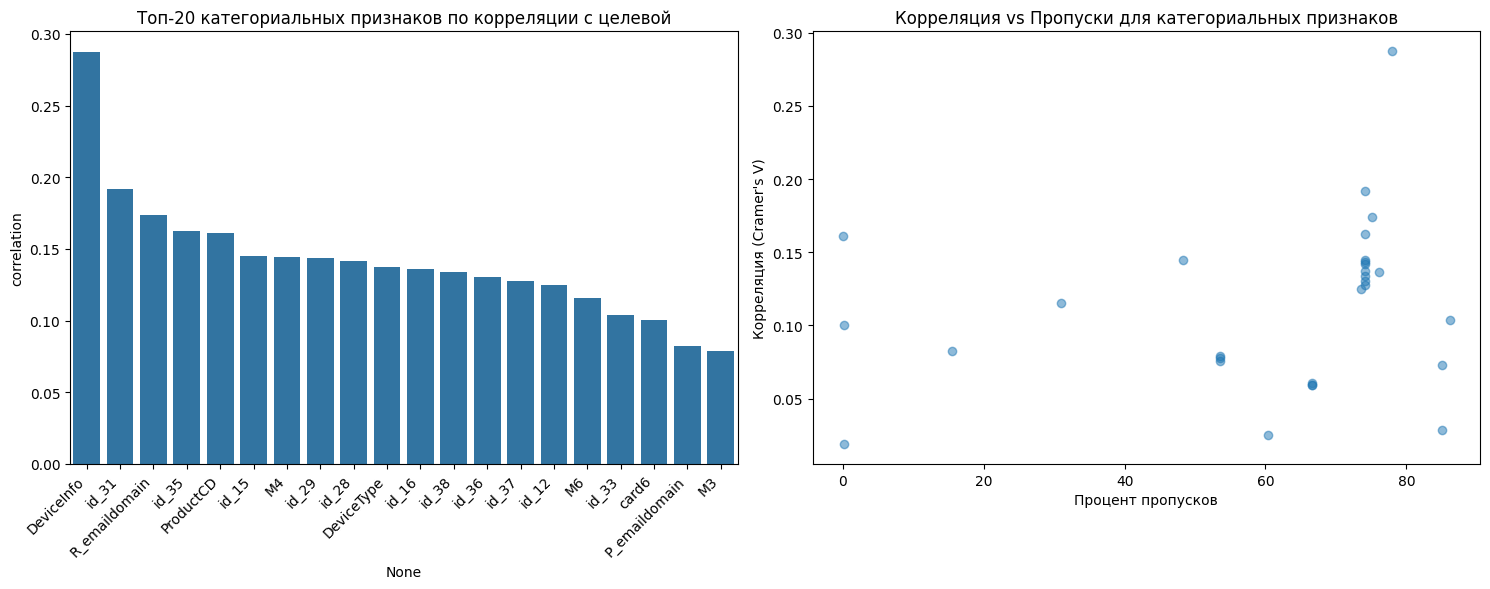


Топ-20 категориальных признаков с наибольшей корреляцией:
              correlation    method missing_pct
DeviceInfo       0.287406  Cramer V   77.977004
id_31            0.191662  Cramer V   74.144732
R_emaildomain    0.173768  Cramer V   75.136448
id_35            0.162282  Cramer V   74.070012
ProductCD        0.160861  Cramer V         0.0
id_15            0.144739  Cramer V   74.070012
M4               0.144584  Cramer V   48.355562
id_29            0.143679  Cramer V   74.070012
id_28            0.141726  Cramer V   74.070012
DeviceType        0.13707  Cramer V   74.105695
id_16            0.136266  Cramer V   76.149478
id_38            0.133735  Cramer V   74.070012
id_36            0.130204  Cramer V   74.070012
id_37            0.127746  Cramer V   74.070012
id_12            0.125183  Cramer V   73.496919
M6               0.115523  Cramer V   31.027472
id_33            0.103771  Cramer V   86.153095
card6            0.100215  Cramer V    0.197816
P_emaildomain    0.082304  Cr

In [70]:
# Визуализация результатов
plt.figure(figsize=(15, 6))

# График топ-20 корреляций
plt.subplot(1, 2, 1)
top_correlations = cat_corrs.head(20)
sns.barplot(x=top_correlations.index, y='correlation', data=top_correlations)
plt.xticks(rotation=45, ha='right')
plt.title('Топ-20 категориальных признаков по корреляции с целевой')
plt.tight_layout()

# Scatter plot для процента пропусков vs корреляция
plt.subplot(1, 2, 2)
plt.scatter(cat_corrs['missing_pct'], cat_corrs['correlation'], alpha=0.5)
plt.xlabel('Процент пропусков')
plt.ylabel('Корреляция (Cramer\'s V)')
plt.title('Корреляция vs Пропуски для категориальных признаков')

plt.tight_layout()
plt.show()

# Выводим топ признаки с их характеристиками
print("\nТоп-20 категориальных признаков с наибольшей корреляцией:")
print(cat_corrs.head(20).round(3))

# Сравнение с числовыми признаками
print("\nСравнение средних корреляций:")
print(f"Средняя корреляция категориальных признаков: {cat_corrs['correlation'].mean():.3f}")
print(f"Средняя корреляция числовых признаков: {tgt_corrs['correlation'].mean():.3f}")

#### Вывод

Корреляции признаков с целевой переменной относительно невысокие, в диапазоне от 0 до 0,37.

### Анализ целевой переменной

In [74]:
# Вычисляем процентное соотношение классов
fraud_percentage = y_train.mean() * 100
non_fraud_percentage = 100 - fraud_percentage

print(f"Мошеннических транзакций: {y_train.sum()} ({fraud_percentage:.2f}%)")
print(f"Соотношение обычных транзакций к мошенническим: {non_fraud_percentage/fraud_percentage:.2f}:1")


Мошеннических транзакций: 14721 (3.53%)
Соотношение обычных транзакций к мошенническим: 27.36:1


#### Вывод

1. Сильный дисбаланс классов: 
   - Мошеннические транзакции составляют значительное меньшинство

2. Последствия для моделирования:
   - Необходимо использовать метрики, устойчивые к дисбалансу классов (AUC-ROC, precision-recall)
   - Рассмотреть методы работы с несбалансированными данными:
     * Взвешивание классов (class_weights)
     * Сэмплирование (SMOTE, RandomUnderSampler)
     * Ансамблевые методы

3. Стратегия валидации:
   - Использовать стратифицированную кросс-валидацию для сохранения пропорций классов
   - Оценивать модель на различных метриках, не только accuracy


### Анализ попарных корреляций числовых признаков

Для анализа корреляций возьмем признаки с числом пропусков не более заданного порога. Для полного анализа установим уровень = 100%

In [75]:
THRESHOLD_MISSING_PRC = 100
features_to_analyze = missing_train_prc[missing_train_prc <= THRESHOLD_MISSING_PRC].index.tolist()
features_to_analyze.sort()

# Создаем датафрейм только с нужными признаками
X_corr = X_train[features_to_analyze].select_dtypes(exclude=['object', 'category']).copy()

# Вычисляем корреляционную матрицу
correlation_matrix = X_corr.corr()
print(f"Количество признаков с пропусками менее {THRESHOLD_MISSING_PRC}%: {X_corr.shape[1]}")

Количество признаков с пропусками менее 100%: 400


Визуализировать матрицу ковариаций для 400 признаков не имеет смысла - она нечитаемая.    
Исследуем попарные корреляции признаков.

#### Выбор порогового значения попарной корреляции

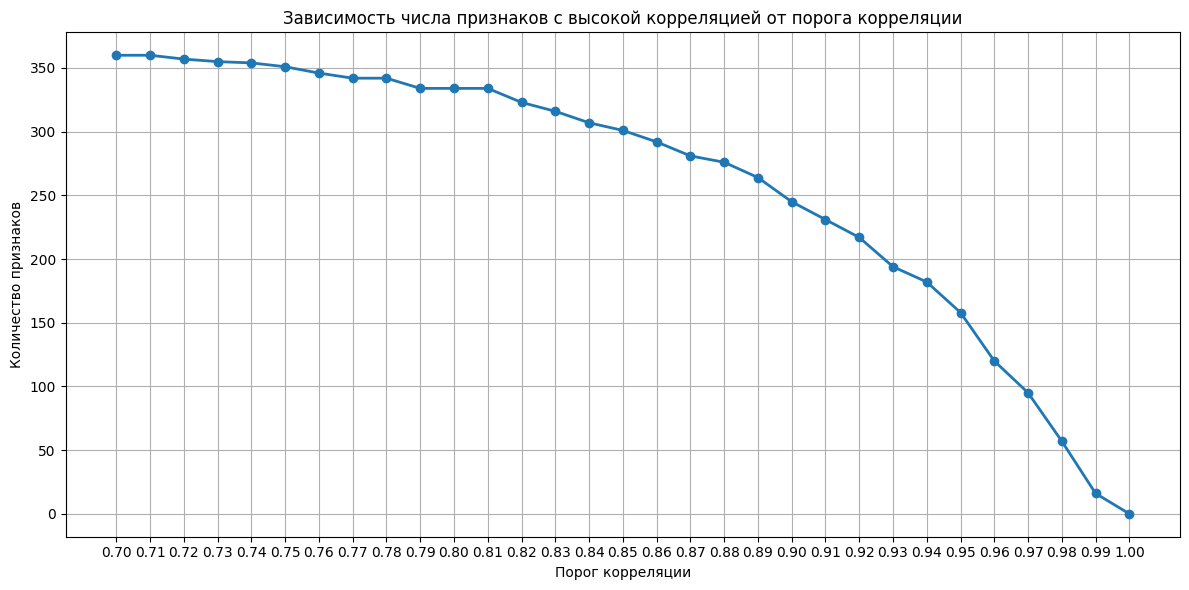

In [76]:
# Построим график зависимости числа признаков с высокой корреляцией от порога корреляции
thresholds = np.arange(0.7, 1.0, 0.01)
feature_counts = []

for threshold in thresholds:
    # Находим признаки с корреляцией выше порога
    high_corr_count = (correlation_matrix.abs() > threshold).sum() - 1  # вычитаем 1, чтобы не учитывать корреляцию признака с самим собой
    high_corr_count = high_corr_count[high_corr_count > 0]
    # Добавляем количество признаков с высокой корреляцией
    feature_counts.append(len(high_corr_count))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, feature_counts, marker='o', linestyle='-', linewidth=2)
plt.title('Зависимость числа признаков с высокой корреляцией от порога корреляции')
plt.xlabel('Порог корреляции')
plt.ylabel('Количество признаков')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


Кажется, что значение 0.85 приемлемо, т.к. это высокая корреляция и при этом число коррелирующих равно 301, что дает хорошие шансы на значительное сокращение числа признаков после анализа.

In [86]:
# Находим признаки с корреляцией выше порога
THRESHOLD_CORRELATION = 0.85
high_corr = (correlation_matrix.abs() > THRESHOLD_CORRELATION).sum() - 1  # вычитаем 1, чтобы не учитывать корреляцию признака с самим собой
high_corr = high_corr[high_corr > 0].sort_values(ascending=False)

# словарь признаков, с которыми высокая корреляция
high_corr_features = {}
for feature in high_corr.index:
    # Находим все признаки, которые сильно коррелируют с текущим
    correlated_features = correlation_matrix[feature][correlation_matrix[feature].abs() > THRESHOLD_CORRELATION].index.tolist()
    # Удаляем сам признак из списка
    correlated_features.remove(feature)
    high_corr_features[feature] = correlated_features

# Преобразуем в Series для удобства отображения
high_corr_with_features = pd.Series(high_corr_features, index=high_corr.index).sort_values(key=lambda x: x.map(len), ascending=False)

print(f"Количество признаков с корреляцией >{THRESHOLD_CORRELATION}: {len(high_corr)}")
if len(high_corr) > 0:
    print("Топ-10 признаков с наибольшим количеством высоких корреляций:")
    print(high_corr_with_features.head(10))


Количество признаков с корреляцией >0.85: 301
Топ-10 признаков с наибольшим количеством высоких корреляций:
V50    [V15, V16, V17, V18, V21, V22, V302, V31, V32,...
V31    [V15, V16, V17, V18, V21, V22, V32, V33, V34, ...
V42    [V15, V17, V18, V21, V22, V302, V304, V31, V32...
V71    [V15, V16, V21, V22, V31, V32, V33, V34, V42, ...
V92    [V15, V16, V17, V21, V22, V31, V32, V33, V34, ...
V21    [V17, V18, V22, V302, V304, V31, V32, V42, V43...
V72    [V15, V16, V21, V31, V32, V33, V34, V42, V50, ...
V84    [V17, V18, V21, V22, V302, V304, V31, V32, V42...
V57    [V15, V16, V21, V31, V32, V33, V34, V42, V50, ...
V93    [V15, V16, V21, V22, V31, V32, V33, V42, V50, ...
dtype: object


#### Визуализация корреляций признаков

Количество компонент связности: 58


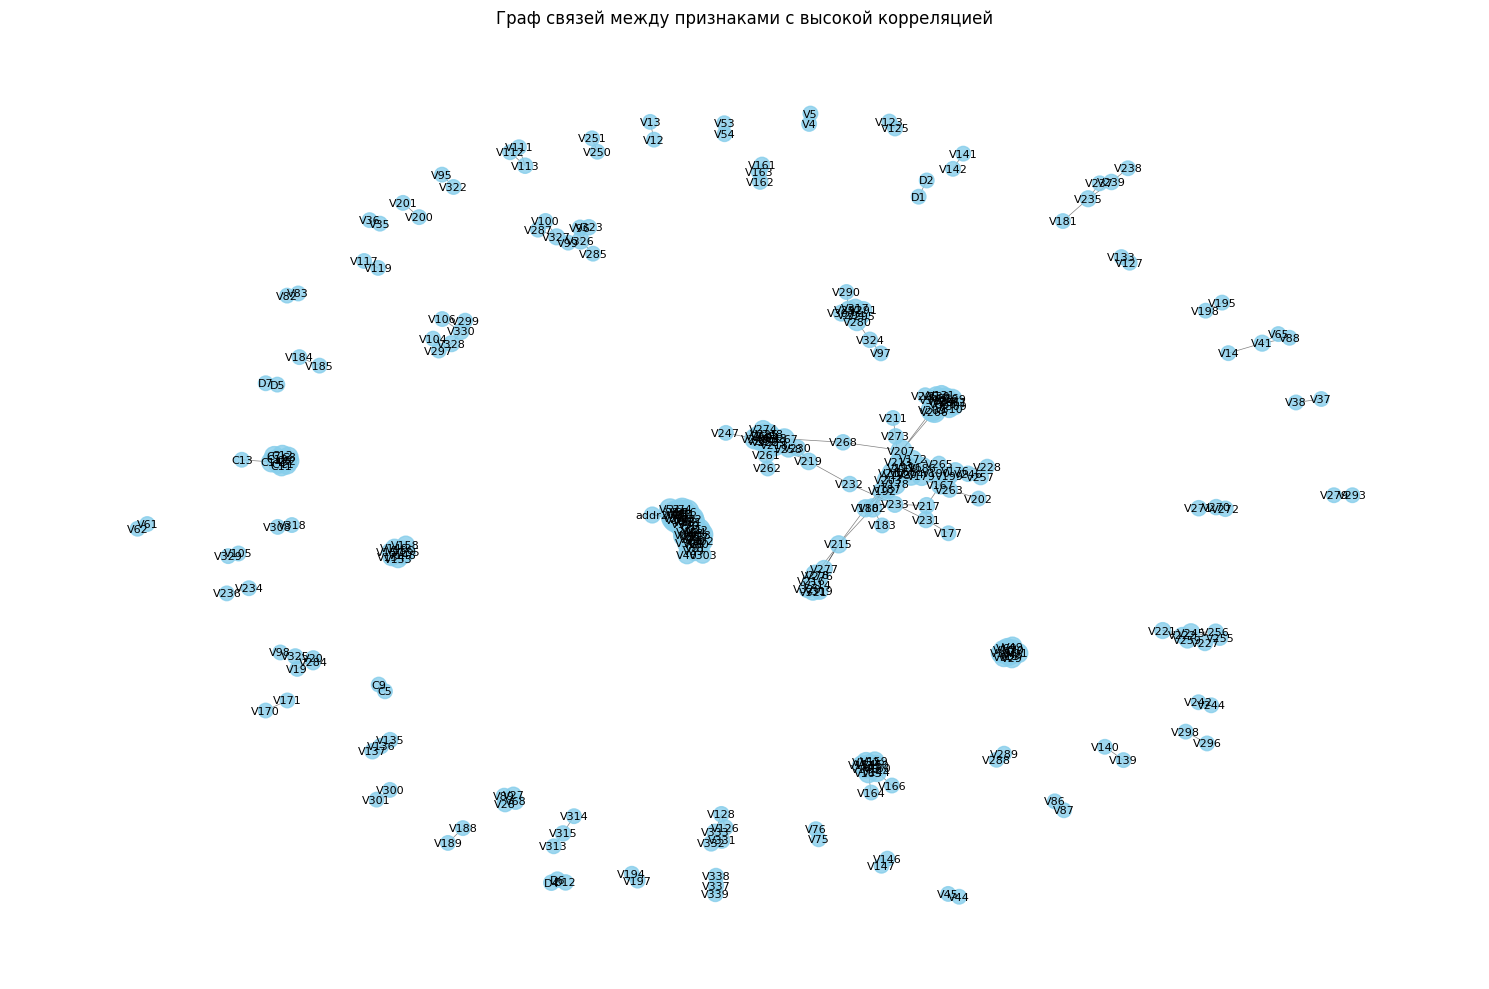

In [89]:
# Создаем граф связей между признаками
import networkx as nx
import matplotlib.pyplot as plt

# Создаем граф
G = nx.Graph()

# Добавляем узлы (признаки)
for feature in high_corr.index:
    G.add_node(feature)

# Добавляем ребра (связи между признаками с высокой корреляцией)
for feature, correlated in high_corr_features.items():
    for corr_feature in correlated:
        G.add_edge(feature, corr_feature)

# Находим компоненты связности в графе
connected_components = list(nx.connected_components(G))
print(f"Количество компонент связности: {len(connected_components)}")
# Визуализируем граф связей между признаками
plt.figure(figsize=(15, 10))

# Используем spring layout для размещения узлов
pos = nx.spring_layout(G, seed=42)

# Определяем размер узлов в зависимости от количества связей
node_size = [100 + 10 * len(high_corr_features.get(node, [])) for node in G.nodes()]

# Рисуем граф
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title('Граф связей между признаками с высокой корреляцией')
plt.axis('off')
plt.tight_layout()
plt.show()


Размеры 12 крупнейших компонент связности: [77, 39, 11, 11, 10, 10, 8, 8, 7, 6, 5, 5]


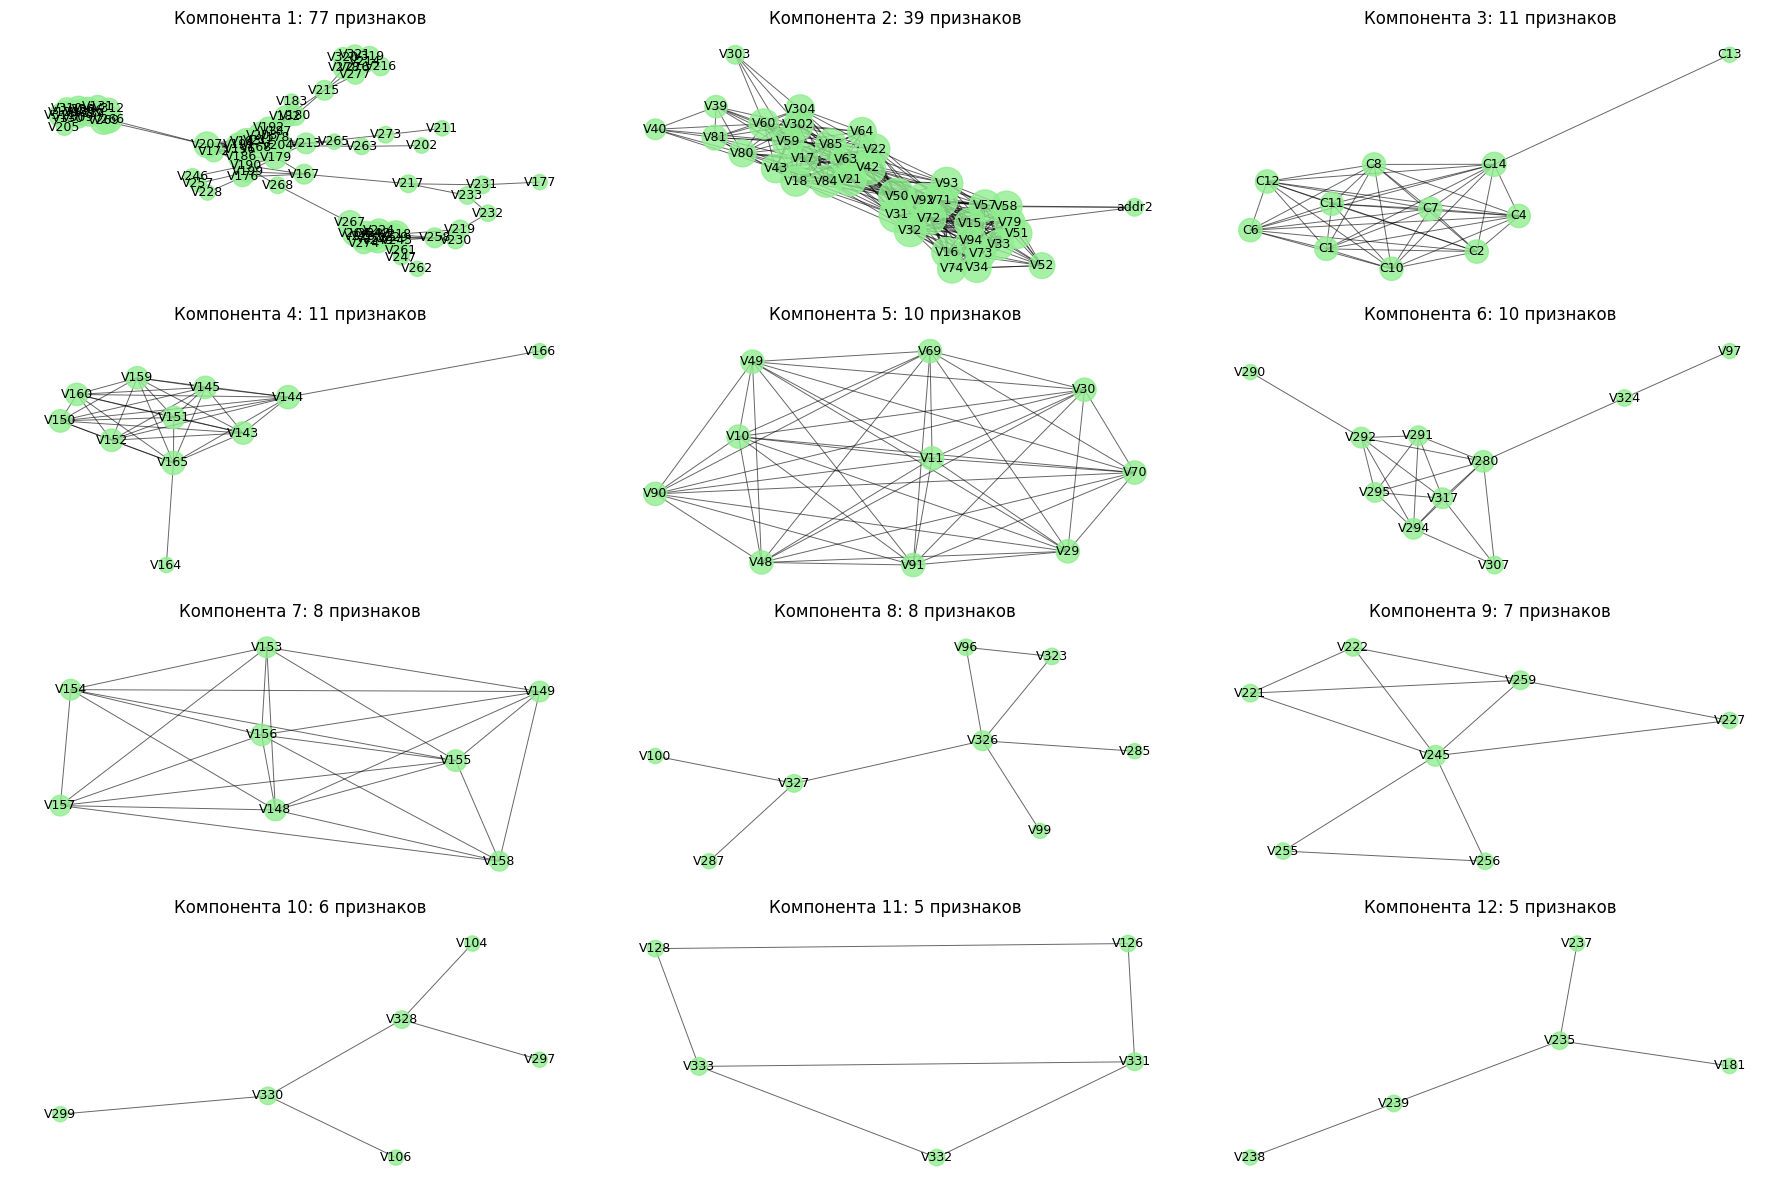

In [90]:
# Визуализируем самые крупные компоненты связности
NUMBER_OF_LARGEST_COMPONENTS = 12
largest_components = sorted(connected_components, key=len, reverse=True)[:NUMBER_OF_LARGEST_COMPONENTS]
print(f"Размеры {NUMBER_OF_LARGEST_COMPONENTS} крупнейших компонент связности: {[len(comp) for comp in largest_components]}")

# Создаем подграфы для крупнейших компонент
plt.figure(figsize=(18, 12))
for i, component in enumerate(largest_components):
    if len(component) > 1:  # Визуализируем только если в компоненте больше 1 узла
        plt.subplot((NUMBER_OF_LARGEST_COMPONENTS+1)//3, 3, i+1)
        
        # Создаем подграф для компоненты
        subgraph = G.subgraph(component)
        
        # Размещаем узлы
        subpos = nx.spring_layout(subgraph, seed=i)
        
        # Определяем размер узлов
        subnode_size = [100 + 20 * len(high_corr_features.get(node, [])) for node in subgraph.nodes()]
        
        # Рисуем подграф
        nx.draw_networkx_nodes(subgraph, subpos, node_size=subnode_size, node_color='lightgreen', alpha=0.8)
        nx.draw_networkx_edges(subgraph, subpos, width=0.7, alpha=0.6)
        nx.draw_networkx_labels(subgraph, subpos, font_size=9, font_family='sans-serif')
        
        plt.title(f'Компонента {i+1}: {len(component)} признаков')
        plt.axis('off')

plt.tight_layout()
plt.show()


#### Обор признаков для удаления

**Признаки с высокой попарной корреляцией будем удалять.** 

Но из визуализации видно, что нельзя оставлять только один признак из компоненты связности, т.к. графы компонент не полносвязные, т.е. не все признаки, попавшие в компоненту, имеют одинаково высокую корреляцию со всеми другими признаками в этой же компоненте.

Удалять будем по такому правилу (можно даже не обращать внимание на компоненты связности):
1. из списка `high_corr_features` взять признак, с максимальным числом связей (т.е. попарных корреляций выше порога)
2. если есть несколько признаков с одинаковым числом связей, тогда взять тот, у которго наименьшая корреляция с целевой переменной
3. удалить этот признак (добавить его в список на удаление)
4. удалить этот признак из списков связности всех остальных признаков
5. повторять п.1 пока будут непустые списки связности.

Таким образом мы будем "вырывать" на каждой итерации самый связанный признак из графа. Иногда это будет приводить к распаду компоненты связности на несколько. В конце граф распадется на отдельные вершины без связей, т.е. не останется признаков имеющих корреляцию выше заданного порога.

In [97]:
# Формируем список признаков для удаления
features_to_remove = []

# Копируем словарь, чтобы не изменять оригинал
tmp_high_corr_features = high_corr_features.copy()

# Удаляем признаки по правилу выше
while any(len(corr_list) > 0 for corr_list in tmp_high_corr_features.values()):
    # 1. Находим признаки с максимальным числом связей
    max_connections = max(len(corr_list) for corr_list in tmp_high_corr_features.values())
    max_connected_features = [f for f, corr_list in tmp_high_corr_features.items() 
                             if len(corr_list) == max_connections]
    
    # 2. Если несколько признаков с одинаковым числом связей, выбираем с наименьшей корреляцией с целевой
    if len(max_connected_features) > 1:
        feature_to_remove = min(max_connected_features, key=lambda f: tgt_corrs.loc[f, "correlation"])
    else:
        feature_to_remove = max_connected_features[0]
    
    # 3. Добавляем этот признак в список на удаление
    features_to_remove.append(feature_to_remove)
    
    # 4. Удаляем этот признак из списков связности всех остальных признаков
    for feature in tmp_high_corr_features:
        if feature_to_remove in tmp_high_corr_features[feature]:
            tmp_high_corr_features[feature].remove(feature_to_remove)
    
    # Удаляем сам признак из словаря
    tmp_high_corr_features.pop(feature_to_remove, None)

print(f"Количество признаков для удаления: {len(features_to_remove)}")
print("Примеры признаков для удаления:")
print(features_to_remove[:10])  # Выводим первые 10 признаков для удаления

Количество признаков для удаления: 190
Примеры признаков для удаления:
['V50', 'V31', 'V71', 'V42', 'V92', 'V59', 'V72', 'V60', 'V32', 'V266']


#### Вывод

1. Мультиколлинеарность:
   - Присутствует значительное число сильно коррелирующих признаков
   - Это может указывать на избыточность данных
   - Необходимо рассмотреть удаление части признаков для уменьшения размерности

2. Группы признаков:
   - Выделяются группы сильно коррелирующих признаков
   - Вероятно, эти группы отражают различные аспекты одних и тех же характеристик транзакций
   - Возможно создание агрегированных признаков на основе этих групп или удаление большинства признаков группы

3. Стратегия обработки:
   - Удалить сильно коррелирующие признаки, оставив по одному из каждой группы
   - При выборе между коррелирующими признаками учитывать корреляцию с целевой переменной
   - Рассмотреть создание новых признаков на основе выявленных взаимосвязей

4. Стратегия моделирования:
   - Использовать алгоритмы, устойчивые к мультиколлинеарности (деревья решений, градиентный бустинг)
   - Применить методы снижения размерности (PCA, feature selection)
   - Провести эксперименты с различными наборами признаков

### Обработка признаков

#### Удаление отобранных признаков

In [98]:
# Удаляем отобранные признаки из X_train
print(f"Форма X_train до удаления признаков: {X_train.shape}")

# Удаляем признаки, которые были определены как сильно коррелирующие
X_train = X_train.drop(columns=features_to_remove)

print(f"Форма X_train после удаления признаков: {X_train.shape}")
print(f"Количество оставшихся признаков: {X_train.shape[1]}")

print(f"Форма X_test до удаления признаков: {X_test.shape}")
X_test = X_test.drop(columns=features_to_remove)
print(f"Форма X_test после удаления признаков: {X_test.shape}")


Форма X_train до удаления признаков: (417559, 431)
Форма X_train после удаления признаков: (417559, 241)
Количество оставшихся признаков: 241
Форма X_test до удаления признаков: (172981, 431)
Форма X_test после удаления признаков: (172981, 241)


In [101]:
end_mem = X_train.memory_usage().sum() / 1024**2
print('X_train : размер после удаления признаков: {:.2f} MB'.format(end_mem))
end_mem = X_test.memory_usage().sum() / 1024**2
print('X_test  : размер после удаления признаков: {:.2f} MB'.format(end_mem))


X_train : размер после удаления признаков: 221.87 MB
X_test  : размер после удаления признаков: 93.27 MB


#### Заполнение пропусков

In [103]:
# Обновим процент пропущенных значений в признаках, т.к. признаки удалялись
missing_train = X_train.isna().sum()
missing_train_prc = X_train.isna().mean().sort_values(ascending=False) * 100

missing_test = X_test.isna().sum()
missing_test_prc = X_test.isna().mean().sort_values(ascending=False) * 100


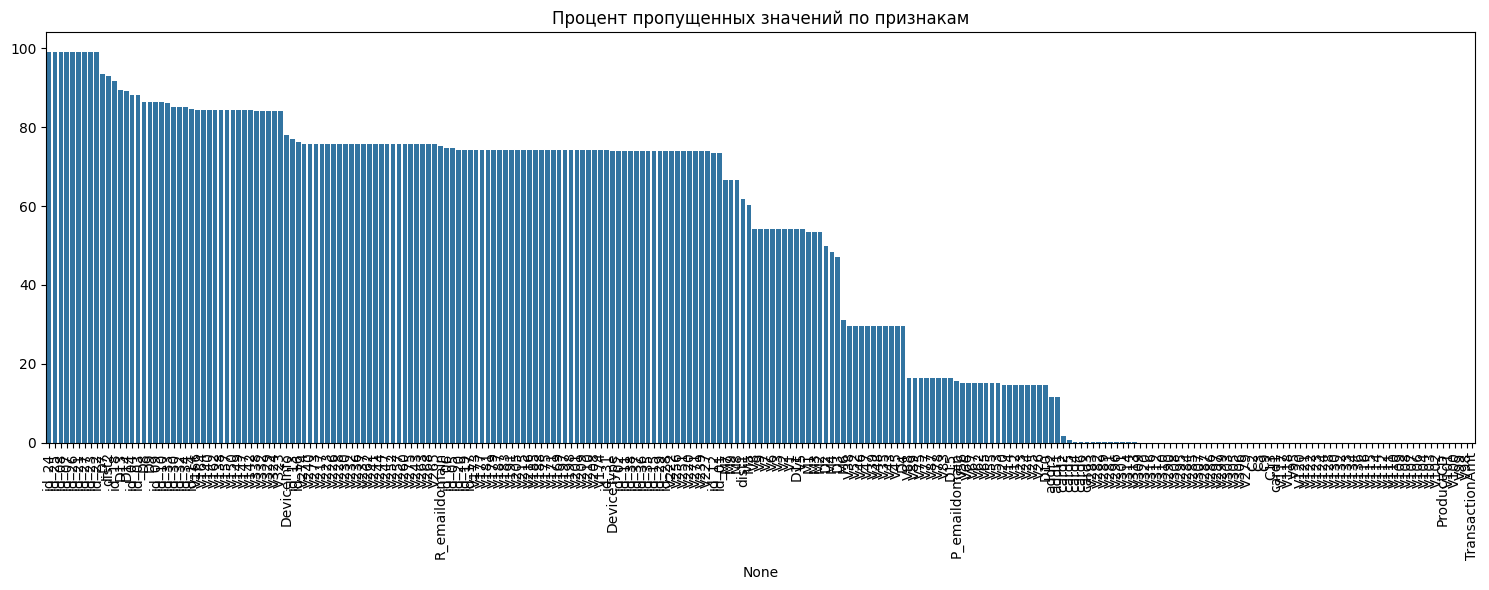

In [104]:
# Визуализация пропущенных значений
plt.figure(figsize=(15, 6))
sns.barplot(x=missing_train_prc.index, y=missing_train_prc.values)
plt.xticks(rotation=90)
plt.title('Процент пропущенных значений по признакам')
plt.tight_layout()
plt.show()

In [106]:
# Разделим признаки на группы по проценту пропусков
def get_features_by_missing_percentage(missing_prc):
    critical = [col for col, prc in missing_prc.items() if prc > 95]
    high = [col for col, prc in missing_prc.items() if 50 <= prc <= 95]
    medium = [col for col, prc in missing_prc.items() if 10 <= prc < 50]
    low = [col for col, prc in missing_prc.items() if 0 < prc < 10]
    return {
        'critical': critical,
        'high': high,
        'medium': medium,
        'low': low
    }


def categorize_missing(missing_prc):
    categories = get_features_by_missing_percentage(missing_prc)
    
    for category, features in categories.items():
        print(f"\n{category}: {len(features)} признаков")
        if len(features) > 0:
            print(f"Примеры: {', '.join(features[:5])}")

# Анализ для тренировочного набора
print("Анализ пропусков в тренировочном наборе:")
categorize_missing(missing_train_prc)

# Проверим типы данных признаков с пропусками
print("\nТипы данных признаков с пропусками:")
print(df_train[missing_train[missing_train > 0].index].dtypes.value_counts())

Анализ пропусков в тренировочном наборе:

critical: 9 признаков
Примеры: id_24, id_25, id_08, id_07, id_26

high: 122 признаков
Примеры: D7, dist2, id_18, D13, D14

medium: 40 признаков
Примеры: D2, M4, D3, M6, V38

low: 32 признаков
Примеры: card2, card5, card4, card6, card3

Типы данных признаков с пропусками:
UInt8       110
float32      31
UInt16       17
category     12
Int8          9
Int16         5
category      4
category      1
category      1
category      1
category      1
category      1
category      1
category      1
UInt32        1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64


**Стратегия заполнения пропусков**

| Группа пропусков | Количество признаков | Примеры признаков | Стратегия для числовых | Стратегия для категориальных |
|------------------|----------------------|-------------------|------------------------|------------------------------|
| Критические (>95%) | 9 | - | Удалить признаки | Удалить признаки |
| Высокие (50-95%) | 122 | D7, D13, D14 | Создать бинарный флаг наличия значения; Заполнить медианой или -999 | Создать отдельную категорию "Missing"; Создать бинарный флаг наличия значения |
| Средние (10-50%) | 40 | D2, M4, D3, M6 | Использовать IterativeImputer для взаимосвязанных признаков; Или SimpleImputer с стратегией 'median' | SimpleImputer с стратегией 'most_frequent' |
| Низкие (0-10%) | 32 | card2-card6 | SimpleImputer с стратегией 'median' | SimpleImputer с стратегией 'most_frequent' |


Для критических пропусков (>95%, 9 признаков):
- удалить эти признаки, так как они содержат слишком мало информации
Для высокого процента пропусков (50-95%, 122 признака):
- Для числовых признаков (D7, D13, D14 и т.д.): 
  - Создать бинарный флаг наличия значения
  - Заполнить медианой
- Для категориальных:
  - Создать отдельную категорию "Missing"
  - Создать бинарный флаг наличия значения
Для среднего процента пропусков (10-50%, 40 признаков):
- Для числовых (D2, M4, D3, M6):
  - Использовать IterativeImputer для взаимосвязанных признаков
- Для категориальных:
  - SimpleImputer с стратегией 'most_frequent'
Для низкого процента пропусков (0-10%, 32 признака):
- Для числовых:
  - SimpleImputer с стратегией 'median'
- Для категориальных (card2-card6):
  - SimpleImputer с стратегией 'most_frequent'


In [107]:
# Реализация стратегии заполнения пропусков

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
from tqdm import tqdm

# Создаем копии датасетов для обработки
X_train_proc = X_train.copy()
X_test_proc = X_test.copy()

missing_categories = get_features_by_missing_percentage(missing_train_prc)

# 1. Удаляем признаки с критическим процентом пропусков (>95%)
print(f"Удаляем {len(missing_categories['critical'])} признаков с критическим процентом пропусков (>95%)")
X_train_proc = X_train_proc.drop(columns=missing_categories['critical'])
X_test_proc = X_test_proc.drop(columns=missing_categories['critical'])

# Разделяем признаки на числовые и категориальные
numeric_features = X_train_proc.select_dtypes(exclude=['object', 'category']).columns.tolist()
categorical_features = X_train_proc.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. Обработка признаков с высоким процентом пропусков (50-95%)
print(f"Обрабатываем {len(missing_categories['high'])} признаков с высоким процентом пропусков (50-95%)")
for feature in tqdm(missing_categories['high']):
    if feature in X_train_proc.columns:
        # Создаем бинарный флаг наличия значения
        X_train_proc[f'{feature}_missing'] = X_train_proc[feature].isna().astype('uint8')
        X_test_proc[f'{feature}_missing'] = X_test_proc[feature].isna().astype('uint8')
        
        if feature in numeric_features:
            # Для числовых признаков заполняем медианой
            median_value = X_train_proc[feature].median()
            X_train_proc[feature] = X_train_proc[feature].fillna(median_value)
            X_test_proc[feature] = X_test_proc[feature].fillna(median_value)
        elif feature in categorical_features:
            # Для категориальных признаков создаем категорию "Missing"
            # Сначала проверяем, является ли признак категориальным типом
            if isinstance(X_train_proc[feature].dtype, pd.CategoricalDtype):
                # Добавляем новую категорию "Missing" к существующим категориям
                X_train_proc[feature] = X_train_proc[feature].cat.add_categories("Missing")
                X_train_proc[feature] = X_train_proc[feature].fillna("Missing")
                
                # То же самое для тестового набора
                if feature in X_test_proc.columns:
                    X_test_proc[feature] = X_test_proc[feature].cat.add_categories("Missing")
                    X_test_proc[feature] = X_test_proc[feature].fillna("Missing")
            else:
                # Если это обычный объектный тип, просто заполняем
                X_train_proc[feature] = X_train_proc[feature].fillna("Missing")
                if feature in X_test_proc.columns:
                    X_test_proc[feature] = X_test_proc[feature].fillna("Missing")

# 3. Обработка признаков со средним процентом пропусков (10-50%) (около 3 минут)
print(f"Обрабатываем {len(missing_categories['medium'])} признаков со средним процентом пропусков (10-50%)")
# Разделяем на числовые и категориальные
medium_numeric = [f for f in missing_categories['medium'] if f in numeric_features]
medium_categorical = [f for f in missing_categories['medium'] if f in categorical_features]

# Для числовых признаков используем IterativeImputer
if medium_numeric:
    imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train_proc[medium_numeric] = pd.DataFrame(
        imputer.fit_transform(X_train_proc[medium_numeric]), 
        columns=medium_numeric,
        index=X_train_proc.index
    )
    X_test_proc[medium_numeric] = pd.DataFrame(
        imputer.transform(X_test_proc[medium_numeric]), 
        columns=medium_numeric,
        index=X_test_proc.index
    )

# Для категориальных признаков используем SimpleImputer с most_frequent
if medium_categorical:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    for feature in medium_categorical:
        if feature in X_train_proc.columns:
            # Исправление: преобразуем результат в одномерный массив перед присваиванием
            X_train_proc[feature] = cat_imputer.fit_transform(X_train_proc[[feature]]).ravel()
            X_test_proc[feature] = cat_imputer.transform(X_test_proc[[feature]]).ravel()

# 4. Обработка признаков с низким процентом пропусков (0-10%)
print(f"Обрабатываем {len(missing_categories['low'])} признаков с низким процентом пропусков (0-10%)")
# Разделяем на числовые и категориальные
low_numeric = [f for f in missing_categories['low'] if f in numeric_features]
low_categorical = [f for f in missing_categories['low'] if f in categorical_features]

# Для числовых признаков используем SimpleImputer с median
if low_numeric:
    num_imputer = SimpleImputer(strategy='median')
    X_train_proc[low_numeric] = pd.DataFrame(
        num_imputer.fit_transform(X_train_proc[low_numeric]), 
        columns=low_numeric,
        index=X_train_proc.index
    )
    X_test_proc[low_numeric] = pd.DataFrame(
        num_imputer.transform(X_test_proc[low_numeric]), 
        columns=low_numeric,
        index=X_test_proc.index
    )

# Для категориальных признаков используем SimpleImputer с most_frequent
if low_categorical:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    for feature in low_categorical:
        if feature in X_train_proc.columns:
            # Исправление: преобразуем результат в одномерный массив перед присваиванием
            X_train_proc[feature] = cat_imputer.fit_transform(X_train_proc[[feature]]).ravel()
            X_test_proc[feature] = cat_imputer.transform(X_test_proc[[feature]]).ravel()


Удаляем 9 признаков с критическим процентом пропусков (>95%)
Обрабатываем 122 признаков с высоким процентом пропусков (50-95%)


 59%|█████▉    | 72/122 [00:00<00:00, 142.52it/s]/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/1801472518.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_proc[f'{feature}_missing'] = X_train_proc[feature].isna().astype('uint8')
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/1801472518.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_proc[f'{feature}_missing'] = X_test_proc[feature].isna().astype('uint8')
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_87830/

Обрабатываем 40 признаков со средним процентом пропусков (10-50%)


/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Обрабатываем 32 признаков с низким процентом пропусков (0-10%)


In [108]:
# Проверяем, остались ли пропуски
missing_train_after = X_train_proc.isna().sum()
missing_test_after = X_test_proc.isna().sum()

print(f"\nПосле обработки:")
print(f"Количество признаков с пропусками в тренировочном наборе: {sum(missing_train_after > 0)}")
print(f"Количество признаков с пропусками в тестовом наборе: {sum(missing_test_after > 0)}")

# Если остались пропуски, выводим информацию о них
if sum(missing_train_after > 0) > 0:
    print("\nПризнаки с оставшимися пропусками в тренировочном наборе:")
    print(missing_train_after[missing_train_after > 0])

if sum(missing_test_after > 0) > 0:
    print("\nПризнаки с оставшимися пропусками в тестовом наборе:")
    print(missing_test_after[missing_test_after > 0])

# Сохраняем обработанные данные для дальнейшего использования
X_train_processed = X_train_proc.copy()
X_test_processed = X_test_proc.copy()

print(f"\nРазмеры обработанных данных:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")



После обработки:
Количество признаков с пропусками в тренировочном наборе: 0
Количество признаков с пропусками в тестовом наборе: 31

Признаки с оставшимися пропусками в тестовом наборе:
V95     314
V98     314
V99     314
V100    314
V101    314
V102    314
V103    314
V104    314
V106    314
V107    314
V108    314
V109    314
V110    314
V111    314
V112    314
V114    314
V115    314
V116    314
V117    314
V118    314
V120    314
V121    314
V122    314
V123    314
V124    314
V128    314
V130    314
V132    314
V133    314
V134    314
V136    314
dtype: int64

Размеры обработанных данных:
X_train_processed: (417559, 354)
X_test_processed: (172981, 354)


В тестовых данных встретились 314 пропусщенных значений в 31 признаке, что составляет всего 0,18%.  
Поэтому просто заменим на медианы.

In [109]:
for col in missing_test_after[missing_test_after > 0].index:
    X_test_proc[col] = X_test_proc[col].fillna(X_test_proc[col].median())

In [110]:
# Проверяем, остались ли пропуски
missing_train_after = X_train_proc.isna().sum()
missing_test_after = X_test_proc.isna().sum()

print(f"\nПосле обработки:")
print(f"Количество признаков с пропусками в тренировочном наборе: {sum(missing_train_after > 0)}")
print(f"Количество признаков с пропусками в тестовом наборе: {sum(missing_test_after > 0)}")

# Если остались пропуски, выводим информацию о них
if sum(missing_train_after > 0) > 0:
    print("\nПризнаки с оставшимися пропусками в тренировочном наборе:")
    print(missing_train_after[missing_train_after > 0])

if sum(missing_test_after > 0) > 0:
    print("\nПризнаки с оставшимися пропусками в тестовом наборе:")
    print(missing_test_after[missing_test_after > 0])

# Сохраняем обработанные данные для дальнейшего использования
X_train_processed = X_train_proc.copy()
X_test_processed = X_test_proc.copy()

print(f"\nРазмеры обработанных данных:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")



После обработки:
Количество признаков с пропусками в тренировочном наборе: 0
Количество признаков с пропусками в тестовом наборе: 0

Размеры обработанных данных:
X_train_processed: (417559, 354)
X_test_processed: (172981, 354)


In [112]:
end_mem = X_train_processed.memory_usage().sum() / 1024**2
print('X_train : размер после заполнения пропусков: {:.2f} MB'.format(end_mem))
end_mem = X_test_processed.memory_usage().sum() / 1024**2
print('X_test  : размер после заполнения пропусков: {:.2f} MB'.format(end_mem))

X_train : размер после заполнения пропусков: 426.15 MB
X_test  : размер после заполнения пропусков: 177.73 MB


Сохраним обработанные данные, чтобы не тратить время при перезапусках в будущем.

In [114]:
X_train_processed.to_csv('./data/X_train_processed.csv', index=True)
X_test_processed.to_csv('./data/X_test_processed.csv', index=True)
y_train.to_csv('./data/y_train.csv', index=True)

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
# ваши модели здесь


# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваша работа с аномалиями здесь

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста